## Train model

Dependency import

In [1]:
import os
import sys

Add path of project modules to visible area

In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import torch
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torch.nn.functional import one_hot
from datasets import load_from_disk

import sys
import signal
from datetime import date
from omegaconf import OmegaConf
from loguru import logger
import tqdm

from src.model import Text2Emoji
from src.parser import Text2EmojiParser
from src.dataset import Text2EmojiDataset
from src.utils import print_model, seed_all, set_logger
from src.utils.train import evaluate_loss_test, print_learn_curve, evaluate_bleu

Train function

In [30]:
def train_model(model, dataset, n_epoch, print_step, emoji_vocab_size, pad_idx, path_save):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_milestones = [2, 4, 7]
    batch_sizes = [32, 64, 128, 256]
    epoch_emb_requires_grad = 4

    model.to(device=device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 7], gamma=0.464159)
    loss = CrossEntropyLoss()

    history = {'train_loss': [], 'test_loss': []}
    batch_step = 0
    train_loss = 0

    test_learn_curve_increases = 0

    train_data_loader, test_data_loader = dataset.get_data_loader(batch_sizes[0], pad_idx)
    for epoch in range(n_epoch):
        if epoch == epoch_emb_requires_grad:
            model.emb_requires_grad()

        if epoch in batch_milestones:
            train_data_loader, test_data_loader = dataset.get_data_loader(batch_sizes[batch_step], pad_idx)
            batch_step += 1
        batch_size = batch_sizes[batch_step]

        logger.info(f'epoch: {epoch + 1}/{n_epoch}, '
                    f'lr: {scheduler.get_last_lr()}, '
                    f'batch_size: {batch_size}')
        for i, batch in tqdm.tqdm(enumerate(train_data_loader)):
            model.train()

            batch_en_ids = batch['en_ids']
            batch_de_ids = batch['de_ids']
            batch_en_ids = batch_en_ids.to(device=device)
            batch_de_ids = batch_de_ids.to(device=device)

            optimizer.zero_grad()

            logits = model(batch_en_ids, batch_de_ids)
            loss_t = loss(logits, one_hot(batch_de_ids.permute(1, 0)[:, 1:],
                                          num_classes=emoji_vocab_size).to(torch.float))
            loss_t.backward()
            optimizer.step()

            train_loss += loss_t.item()
            if i % print_step == 0 and i != 0:
                model.eval()

                # evaluate
                mean_train_loss = train_loss / print_step
                train_loss = 0
                mean_test_loss = evaluate_loss_test(model, test_data_loader, loss, emoji_vocab_size, device)
                logger.info(f'step: {i}/{len(train_data_loader)}, '
                            f'train_loss: {mean_train_loss}, '
                            f'test_loss: {mean_test_loss}')
                history['train_loss'].append(mean_train_loss)
                history['test_loss'].append(mean_test_loss)

                # save state
                torch.save({
                    'epoch': epoch,
                    'history': history,
                    'model': model.state_dict(),
                    'optim': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'batch_size': batch_size,
                    'loss': loss
                }, f'{path_save}/checkpoint_{date.today()}.pth')

                # callbacks
                if len(history['test_loss']) > 1 and history['test_loss'][-2] < history['test_loss'][-1]:
                    test_learn_curve_increases += 1
                else:
                    test_learn_curve_increases = 0

                if test_learn_curve_increases > 5:
                    return history

        # calculate bleu
        results = evaluate_bleu(model, dataset, device)
        logger.info(f'bleu: {results}')

        scheduler.step()
    model.eval()
    model.to('cpu')

    return history

Set logger

In [5]:
set_logger()

Set paths

In [27]:
path_model_config = '../configs/model.yaml'
path_train_config = '../configs/train.yaml'
path_processing_config = '../configs/processing.yaml'
path_load_parser = '../data/parser'
path_load_embbeding = '../data/transfer/embbeding'
path_load_dataset = '../data/datasets/processed'
path_save_checkpoint = '../data/checkpoints'
path_save_model = '../models'

Set configs

In [7]:
model_config = OmegaConf.load(path_model_config)
train_config = OmegaConf.load(path_train_config)
processing_config = OmegaConf.load(path_processing_config)

In [9]:
st = processing_config.special_tokens
pad_token, sos_token, eos_token, unk_token = st.pad.token, st.sos.token, st.eos.token, st.unk.token
pad_idx, sos_idx, eos_idx, unk_idx = st.pad.id, st.sos.id, st.eos.id, st.unk.id

Set seed

In [10]:
seed_all(train_config.seed)

Load data

In [23]:
logger.info(f'Dataset load')
dataset = load_from_disk(path_load_dataset)

2024-11-02 17:49:44 | INFO | Dataset load


In [24]:
dataset = Text2EmojiDataset(dataset)
dataset.train_test_split(processing_config.data.train_test_ratio)

In [14]:
parser = Text2EmojiParser(pad_token, sos_token, eos_token, unk_token)
parser.load(path_load_parser + '/parser.pt')

In [15]:
embbedings = torch.load(path_load_embbeding + '/embbeding.pt')
embbeding_size = embbedings.shape[1]

In [16]:
logger.info('Model creating')
model = Text2Emoji(parser.text_vocab_size(), parser.emoji_vocab_size(),
                    sos_idx, eos_idx, pad_idx, embbeding_size,
                   model_config.model_architecture.hidden_size,
                   model_config.model_architecture.num_layers,
                   model_config.model_architecture.dropout,
                   model_config.model_architecture.sup_unsup_ratio)
model.init_en_emb(embbedings)

2024-11-02 17:46:12 | INFO | Model creating


In [17]:
print_model(model)

enc.emb.weight 	 torch.Size([11526, 100])
enc.enc0.weight_ih_l0 	 torch.Size([1050, 100])
enc.enc0.weight_hh_l0 	 torch.Size([1050, 350])
enc.enc0.bias_ih_l0 	 torch.Size([1050])
enc.enc0.bias_hh_l0 	 torch.Size([1050])
enc.enc0.weight_ih_l0_reverse 	 torch.Size([1050, 100])
enc.enc0.weight_hh_l0_reverse 	 torch.Size([1050, 350])
enc.enc0.bias_ih_l0_reverse 	 torch.Size([1050])
enc.enc0.bias_hh_l0_reverse 	 torch.Size([1050])
enc.enc0.weight_ih_l1 	 torch.Size([1050, 700])
enc.enc0.weight_hh_l1 	 torch.Size([1050, 350])
enc.enc0.bias_ih_l1 	 torch.Size([1050])
enc.enc0.bias_hh_l1 	 torch.Size([1050])
enc.enc0.weight_ih_l1_reverse 	 torch.Size([1050, 700])
enc.enc0.weight_hh_l1_reverse 	 torch.Size([1050, 350])
enc.enc0.bias_ih_l1_reverse 	 torch.Size([1050])
enc.enc0.bias_hh_l1_reverse 	 torch.Size([1050])
enc.hid_lin.weight 	 torch.Size([350, 700])
enc.hid_lin.bias 	 torch.Size([350])
dec.emb.weight 	 torch.Size([1330, 100])
dec.dec0.weight_ih 	 torch.Size([1050, 100])
dec.dec0.weight

Train model

In [18]:
def signal_capture(sig, frame):
    torch.save(model.state_dict(), f'{path_save_model}/SIGINT_model_weights_{date.today()}.pth')
    sys.exit(0)

In [19]:
signal.signal(signal.SIGINT, signal_capture)

<function _signal.default_int_handler(signalnum, frame, /)>

2024-11-02 17:56:05 | INFO | Model training
2024-11-02 17:56:05 | INFO | epoch: 1/8, lr: [0.001], batch_size: 32


100it [01:05,  1.63it/s]

2024-11-02 17:57:36 | INFO | step: 100/15630, train_loss: 0.03108152646571398, test_loss: 0.031199057510978467


100it [01:30,  1.10it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data/learning_curves/curve_2024-11-02.png'

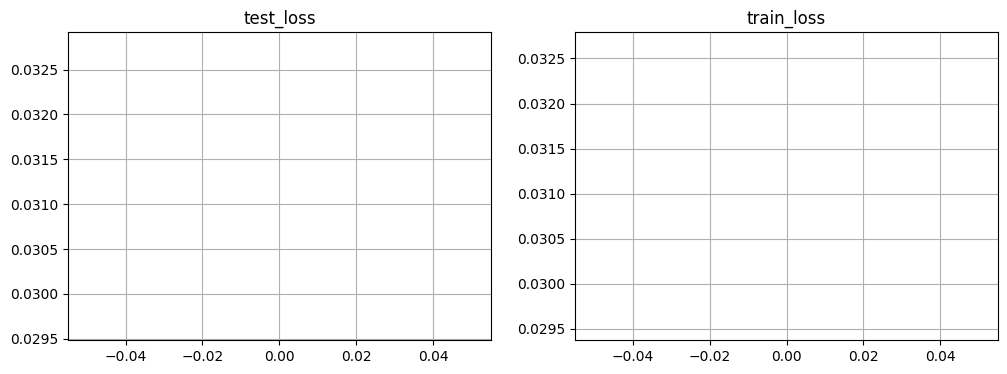

In [29]:
logger.info('Model training')
train_history = train_model(model, dataset,
                            train_config.train_process.epoch,
                            train_config.train_process.print_step,
                            parser.emoji_vocab_size(), pad_idx,
                            path_save_checkpoint)

torch.save(model.state_dict(), f'{path_save_model}/trained_model_weights_{date.today()}.pth')